# **F**ootball **A**nalysis in **R**eal **T**ime using **T**ransformer
This is a Video Transformer model based on ViViT that can caption 17 of the most important events in a soccer game.

Tony Robinson and Tanner Watts

In [ ]:
# mount the dataset (the drive)
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# set teh data directory location
DATA_DIREC = "/content/drive/MyDrive/FARTT/data/"
MAIN_DIREC = "/content/drive/MyDrive/FARTT"

### Setting up all needed libraries and packages

In [ ]:
! pip install SoccerNet --upgrade
! pip install pytorch_lightning
! pip install scikit-video
! pip install torchmetrics
! pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import math
import torch
import torch.nn as nn
import torchvision.models as models
import pytorch_lightning as pl
import SoccerNet
import matplotlib.pyplot as plt
import sys
import os
import cv2
import numpy as np
import torchvision.transforms as transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchmetrics.functional import accuracy

if torch.cuda.is_available:
  print('Good to go!')
else:
  print('Please set GPU via Edit -> Notebook Settings.')

torch.cuda.empty_cache()

Good to go!


# Setup the Dataset #

Unzip the frames

In [ ]:
import zipfile
import os

unzip_data = False
if unzip_data:
  for leagueName in os.listdir(DATA_DIREC):
    print(leagueName)
    for year in os.listdir(DATA_DIREC+leagueName+"/"):
      for game in os.listdir(DATA_DIREC+leagueName+"/"+year+"/"):
        v3LabelsFile_path = DATA_DIREC+leagueName+"/"+year+"/"+game+"/"+ "Labels-v3.json"
        v3FramesZipFile_path = DATA_DIREC+leagueName+"/"+year+"/"+game+"/"+ "Frames-v3.zip"
        unzippedFolder = DATA_DIREC+leagueName+"/"+year+"/"+game+"/"+ "unzippedFramesDir/"

        if os.path.isdir(unzippedFolder):
          continue
        # make sure the necessary v3 files are present
        if (os.path.isfile(v3LabelsFile_path) == True) and (os.path.isfile(v3FramesZipFile_path) == True):
          print(unzippedFolder)
          with zipfile.ZipFile(v3FramesZipFile_path, 'r') as zip_ref:
            zip_ref.extractall(unzippedFolder)

In [ ]:
import json
import pathlib
import os
import zipfile
import shutil



def split_png_images():
  """
  This method will loop through the drive, place
  the images into train and test folders inside of the
  train and test folders will be the class folders
  """
  for leagueName in os.listdir(DATA_DIREC):
    for year in os.listdir(DATA_DIREC+leagueName+"/"):
      for game in os.listdir(DATA_DIREC+leagueName+"/"+year+"/"):
        v3LabelsFile_path = DATA_DIREC+leagueName+"/"+year+"/"+game+"/"+ "Labels-v3.json"
        unzippedFolder = DATA_DIREC+leagueName+"/"+year+"/"+game+"/"+ "unzippedFramesDir/"
        # open the json for parsing
        if not (os.path.isfile(v3LabelsFile_path) and os.path.isdir(unzippedFolder)):
          continue
        game_json = open(v3LabelsFile_path)
        game_dict = json.load(game_json)
        for image in os.listdir(unzippedFolder):
          # get the class label from the json
          image = str(image)
          train_test_valid_folder ="none"
          if image in game_dict["actions"]:
            train_test_valid_folder = game_dict["actions"][image]["imageMetadata"]["set"]
            print(train_test_valid_folder)
          else:
            continue

          print(train_test_valid_folder)
          if train_test_valid_folder != "train":
            continue

          image_label = game_dict["actions"][image]["imageMetadata"]["label"]
          print(image_label)
          if "Shots" in image_label:
            image_label = "Shot"
          else:
            continue

          game_name = game_dict["actions"][image]["imageMetadata"]["localpath"]
          folder_path = DATA_DIREC + train_test_valid_folder + "/" + image_label
          print(folder_path)
          # check to see if the directory exists if not create it
          if os.path.isdir(folder_path):
            print("Exists")
            print(folder_path)
          else:
            print("Doesn't exist")
            os.mkdir(folder_path)
          og_image_path = unzippedFolder + image
          # change the image
          image_name = game + "_" + image
          # do we need the whole path

          # img_full = unzippedFolder + image_name
          print(image_name)
          dst = os.path.join(folder_path, image_name)
          os.rename(og_image_path, dst)

split_im = False
if split_im:
  split_png_images()

In [ ]:
import glob
import numpy as np

## TODO: Figure how to split the data into 3 cats ##
def create_data_sets():
  ## get the sets of images ##
  train_data = []
  test_data = []
  val_data = []

  train_data_path = DATA_DIREC + "train"
  valid_data_path = DATA_DIREC + "valid"
  test_data_path = DATA_DIREC + "test"

  classes = [] #to store class values

  # This creates an array of image paths for train test and valid
  for data_path in glob.glob(train_data_path + '/*'):
    classes.append(data_path.split('/')[-1])
    for path in glob.glob(data_path + '/*'):
      # try :
      #   Image.open(path)
      # except:
      #   print("DNE")
      #   print(path)
      #   continue
      train_data.append(path)


  for data_path in glob.glob(valid_data_path + '/*'):
    for path in glob.glob(data_path + '/*'):
      val_data.append(path)

  for data_path in glob.glob(test_data_path + '/*'):
    for path in glob.glob(data_path + '/*'):
      test_data.append(path)


  # soccernet = SNV3Dataset(args.SoccerNet_path, split=args.split, resolution=(args.resolution_width,args.resolution_height), preload_images=args.preload_images, zipped_images=args.zipped_images, tiny=args.tiny)
  return train_data, test_data, val_data, classes


train_data, test_data, val_data, classes = create_data_sets()
train_data.remove("/content/drive/MyDrive/FARTT/data/train/Foul/2015-02-17 - 22-45 Paris SG 1 - 1 Chelsea_4.png")
if "/content/drive/MyDrive/FARTT/data/train/Foul/2015-02-17 - 22-45 Paris SG 1 - 1 Chelsea_4.png" in train_data:
  print("FAIL")

In [ ]:
print(classes)

['Foul', 'Goal', 'Ball out of play', 'Direct free-kick', 'Clearance', 'Corner', 'Offside', 'Penalty', 'Yellow card', 'Kick-off']


In [ ]:
#creating the dataset
#dataset
#######################################################
#               Define Transforms
#######################################################
import torchvision.transforms.functional as F

def square_pad( image):
  w, h= image.size
  max_wh = np.max([w, h])
  hp = int((max_wh - w) / 2)
  vp = int((max_wh - h) / 2)
  padding = (hp, vp, hp, vp)
  return F.pad(image, padding, 0, 'constant')



train_transforms_deep = A.Compose(
    [
        A.SmallestMaxSize(max_size=350),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=360, p=0.5),
        A.RandomCrop(height=256, width=256),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.MultiplicativeNoise(multiplier=[0.5,2], per_channel=True, p=0.2),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
        ToTensorV2(),
    ]
)


image_size = [3, 480, 854]

train_transforms = A.Compose([
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2(),

])

test_transforms = A.Compose([
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()

])


test_transforms_deep = A.Compose(
    [
        A.SmallestMaxSize(max_size=350),
        A.CenterCrop(height=256, width=256),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

In [ ]:
from PIL import Image
# gives indexes to the classes for easy enumeration
idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}

class Actions_Dataset(torch.utils.data.Dataset):
    def __init__(self, classes, image_paths, transform = None, target_transform = None):
        """
        classes: The classes in the dataset
        image_base_dir: The directory of the folders containing the images
        transform: The trasformations for the Images
        Target_transform: The trasformations for the target

        """
        self.img_labels = classes
        self.transform = transform
        self.target_transform = target_transform
        self.image_paths = image_paths

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
      """
      This method will get the item from the dataset. It will read using cv2
      """
      image_filepath = self.image_paths[idx]
      image = Image.open(image_filepath)
      label = image_filepath.split('/')[-2]
      label = class_to_idx[label]
      image = square_pad(image)
      # here we change the size of the images
      image = image.resize((100, 100))
      image = np.asarray(image)
      if self.transform is not None:
        image = self.transform(image=image)["image"]

      return image, label


In [ ]:
# Define your DataModule (if using one)
class FARTTDataModule(pl.LightningDataModule):
  def __init__(self, classes, train_dir, val_dir, test_dir, train_data_paths,
               test_data_paths, val_data_paths, batch_size=64):
    # Load and preprocess your data
    self.batch_size = batch_size
    self.transform = train_transforms
    self.test_tansform = test_transforms
    self.num_classes = len(classes)
    self.train_data = Actions_Dataset(classes, train_data_paths, self.transform)
    self.val_data = Actions_Dataset(classes, val_data_paths, self.transform)
    self.test_data = Actions_Dataset(classes, test_data_paths, self.test_tansform)

  def setup(self):
    # call the data_loader which will use v3
     print("SETUP")

  def train_dataloader(self):
    # Return a DataLoader for the training data
    return torch.utils.data.DataLoader(self.train_data,
            batch_size=self.batch_size, shuffle=True, num_workers=12)

  def val_dataloader(self):
    # Return a DataLoader for
    return torch.utils.data.DataLoader(self.val_data,
            batch_size=self.batch_size, shuffle=False, num_workers=12)

  def test_dataloader(self):
    return torch.utils.data.DataLoader(self.test_data,
        batch_size=1, shuffle=False, num_workers=12)


In [ ]:
# load in the data splitting it into test train and val
## TODO: Figure how to split the data ##
train_data_path = DATA_DIREC + "/train"
valid_data_path = DATA_DIREC + "/valid"
test_data_path = DATA_DIREC + "/test"
# use the DataModule to pass to the model
data_module = FARTTDataModule(classes, train_data_path, valid_data_path, test_data_path, train_data, test_data, val_data)

# ResNet #

# Visual Transformer (ViT)#


**Patch embeddings**

Patch embeddings are needed in order to the the images into a form that will work with transformers. This will embed the images the same way the paper does.

In [ ]:
class PatchEmbeddings(nn.Module):
  def __init__(self, embed_size, patch_size, in_channels):
    """
    embed_size = transformer embedding size
    patch_size = size of the patch
    in_channes
    """
    super().__init__()
    self.conv = nn.Conv2d(in_channels, embed_size,
                          patch_size, stride=patch_size, device='cuda')

  def forward(self, x):
    """
    x: torch tensor [patches, batch_size, ]
    """
    x = self.conv(x)
    bs, c, h, w = x.shape
    x = x.permute(2, 3, 0, 1)
    x = x.view(h * w, bs, c)
    return x

**Postional Embedding**

This will add a learned postiuonal embedding to the patch embedings.

In [ ]:
class PositionalEmbeddings(nn.Module):
  def __init__(self, embed_size, max_len=5000):
    """
    embed_size: the embedding size of the transformer
    max_len: Is the maxium number of patches
    """
    super().__init__()
    self.positional_encodings = nn.Parameter(torch.zeros(max_len, 1, embed_size),
                                             requires_grad=True)

  def forward(self, x):
    """
    x: patch embedings of shape [patches x batch_size x embed_size]
    """
    my_positional_encodings = self.positional_encodings[:x.shape[0]]
    return x + my_positional_encodings

**Classifcation Head**

Thhis is the two layer MLP that is used to classify the images. It is based on the CLS token embeding.

In [ ]:
class ClassificationHead(nn.Module):
  def __init__(self, embed_size, n_hidden, n_classes):
    """
    embed_size: the embedding size of the transformer
    n_hidden: size of the hidden layer
    n_classes: number of classes in the classfication task
    """
    super().__init__()
    self.linear1 = nn.Linear(embed_size, n_hidden, device='cuda')
    self.act = nn.ReLU()
    self.linear2 = nn.Linear(n_hidden, n_classes, device='cuda')

  def forward(self, x):
    """
    x: the transformer encoding for the CLS token (torch.Tensor)
    """
    x = self.linear1(x)
    x = self.act(x)
    x = self.linear2(x)
    return x

**Multi Head Attention**

This layer is used in the transformer layer. Multi Head attention
calculates the query key and value vectors.

In [ ]:
class QKVSplit(nn.Module):
  def __init__(self, feature_size, heads, d_k, bias):
    """
    Used to transform the key query and value vectors
    feature_size: number of features in the query key and value vecs
    heads: number of heads
    d_k: number of dimentions in vectors in each head
    bias: for the linerar layer
    """
    super().__init__()
    self.linear = nn.Linear(feature_size, heads * d_k, bias=bias, device='cuda')
    self.heads = heads
    self.d_k = d_k
  def forward(self, x):
    """
    x: shape [seq_len, batch_size, embed_size] or [batch_size, embed_size]
    """
    head_shape = x.shape[:-1]
    x = self.linear(x)
    x = x.view(*head_shape, self.heads, self.d_k)
    return x

class MultiHeadAttention(nn.Module):
  def __init__(self, heads, feature_size, dropout_prob, bias= True):
    """
    heads: number of heads
    feature_size: number of features in the query key and value vecs
    """
    super().__init__()
    self.d_k = feature_size // heads
    self.heads = heads
    self.query = QKVSplit(feature_size, heads, self.d_k, bias=bias)
    self.key = QKVSplit(feature_size, heads, self.d_k, bias=bias)
    self.value = QKVSplit(feature_size, heads, self.d_k, bias=True)
    self.softmax = nn.Softmax(dim=1)
    self.output = nn.Linear(feature_size, feature_size, device="cuda")
    self.dropout = nn.Dropout(dropout_prob)
    self.scale = 1 / math.sqrt(self.d_k)
    self.attn = None


  def get_scores(self, query, key):
    """
    This method will calculate the the scores between
    Key Value and Query
    all of which are torch tensors
    """
    return torch.einsum('ibhd,jbhd->ijbh', query, key)

  def prepare_mask(self, mask, query_shape, key_shape):
    """
    mask has shape [seq_len_q, seq_len_k, batch_size] ,
    where first dimension is the query dimension.

    """
    assert mask.shape[0] == 1 or mask.shape[0] == query_shape[0]
    assert mask.shape[1] == key_shape[0]
    assert mask.shape[2] == 1 or mask.shape[2] == query_shape[1]
    mask.unsqueeze(-1)
    return mask

  def forward(self, *, query, key, value, mask=None):
    """
    all params are torch Tensors. This is the forward
    pass through the MHT
    """
    seq_len, batch_size, _ = query.shape
    if mask is not None:
      mask = self.prepare_mask(mask, query.shape, key.shape)
    # set up the query key and value
    query = self.query(query)
    key = self.key(key)
    value = self.value(value)
    scores = self.get_scores(query,key)
    scores *= self.scale
    # add in the masked fill
    if mask is not None:
      scores = scores.masked_fill(mask == 0, float('-inf'))
    # now calcutate the attention
    attn = self.softmax(scores)
    # cacluate x
    x = torch.einsum("ijbh,jbhd->ibhd", attn, value)
    #self.attn = attn.detach() use this if we want to save attn calcs
    x = x.reshape(seq_len, batch_size, -1)
    x = self.output(x)
    return x

**Feed Forward**

This is the feed forward nn.Module. It is used in the transformer layer which is the backbone of our model.

In [ ]:
class FeedForward(nn.Module):
  def __init__(self, num_tokens, d_ff, dropout, is_gated,
               bias1, bias2, bias_gate):
    """
    num_tokens: the number of features in a token embedding
    d_ff: number of features in the hidden layer of the FFN
    dropout: probability for the hidden layer
    is_gated: specifies whether the hidden layer is gated
    bias1: specified whether the first fully connected layer should have a learnable bias
    bias:2 specified whether the second fully connected layer should have a learnable bias
    bias_gate: specified whether the fully connected layer for the gate should have a learnable bias
    """
    super().__init__()
    self.layer1 = nn.Linear(num_tokens, d_ff, bias=bias1, device="cuda")
    self.layer2 = nn.Linear(d_ff, num_tokens, bias=bias2, device="cuda")
    self.dropout = nn.Dropout(dropout)
    self.activation = nn.ReLU()
    self.is_gated = is_gated
    if is_gated:
      self.linear_v = nn.Linear(num_tokens, d_ff, bias=bias_gate, device="cuda")

  def forward(self, x):
    """
    The forward pass of the feed forward method
    """
    g = self.layer1(x)
    g = self.activation(g)
    if self.is_gated:
      x = g * self.linear_v(x)
    else:
      x = g
    x = self.dropout(x)
    x = self.layer2(x)
    return x


**Transformer Layer (the Backbone)**

This is the classic transformer layer from the orgional NLP transformer paper. Attention is all you need. It is broken into self attention src attention feed forward and dropout prop as the params.

In [ ]:
class TransformerLayer(nn.Module):
  def __init__(self, *, embed_size, self_attn, src_attn = None, feed_forward, dropout_prob):
    """
    embed_size: token embedding size
    self_attn: self attention module
    src_attn: source attention module (when this is used in a decoder)
    feed_forward: feed forward module
    dropout_prob: prob of dropping out after self attention and FFN

    """
    super().__init__()
    self.size = embed_size
    self.self_attn = self_attn
    self.src_attn = src_attn
    self.feed_forward = feed_forward
    self.dropout = nn.Dropout(dropout_prob)
    self.norm_self_attn = nn.LayerNorm([embed_size], device="cuda")
    if self.src_attn is not None:
        self.norm_src_attn = nn.LayerNorm([embed_size], device="cuda")
    self.norm_ff = nn.LayerNorm([embed_size], device="cuda")

    self.is_save_ff_input = False

  def forward(self, *, x, mask, src = None, src_mask = None):
    """
    """
    z = self.norm_self_attn(x)
    self_attn = self.self_attn(query=z, key=z, value=z, mask=mask)
    x = x + self.dropout(self_attn)
    if src is not None:
      z = self.norm_src_attn(x)
      attn_src = self.src_attn(query=z, key=src, value=src, mask=src_mask)
      x = x + self.dropout(attn_src)

    z = self.norm_ff(x)
    if self.is_save_ff_input:
      self.ff_input = z.clone()
    ff = self.feed_forward(z)
    x = x + self.dropout(ff)
    return x

**Transformer Encoder**

This is the Transformer Encoder layer. This will be the layer that is use in our final model.

In [ ]:
class Encoder(nn.Module):
  def __init__(self, layer, n_layers):
    """
    layer: Transformer layer from above
    n_layer: number of layers
    """
    super().__init__()
    self.size = layer.size
    self.layers = []
    for lay in range(n_layers):
      self.layers.append(layer)

    self.norm = nn.LayerNorm([layer.size], device="cuda")

  def forward(self, x, mask):
    """
    The froward pass of the Encoder
    """
    for layer in self.layers:
      x = layer(x=x, mask=mask)
    x = self.norm(x)
    return x



**Football Analysis in Real Time using Transformer**

This is our final model. It is based exactly on ViT(an image is worth 16 X 16 words)

In [ ]:
# Define your model using the Pytorch Lightning framework
##Implementation of ViT and all depedncies in pl lighting ##
from torchmetrics.classification import MulticlassAccuracy


class FARTT(pl.LightningModule):
  def __init__(self, transformer_layer, n_layers, patch_emb,
               pos_emb, classification, learning_rate=0.025, num_epocs=100):
    """
    transformer_layer: the transformer layer
    n_layers: the number of transformer layers
    the patch_embedding: patch_emb
    the postion embedding: pos_emb
    the classfication head: classification
    """
    super().__init__()
    # Define the transformer architecture and any necessary components
    self.patch_emb = patch_emb
    self.pos_emb = pos_emb
    self.classification = classification
    self.transformer_layers = []

    for i in range(n_layers):
      self.transformer_layers.append(transformer_layer)

    self.cls_token_emb = nn.Parameter(torch.randn(1, 1, transformer_layer.size), requires_grad=True)
    self.ln = nn.LayerNorm([transformer_layer.size], device="cuda")
    self.compute_loss = nn.CrossEntropyLoss()
    self.lr = learning_rate
    self.num_epocs = num_epocs

    self.save_hyperparameters()

    # self.test_accuracy = MulticlassAccuracy(num_classes=len(classes),
    #                             average=None).to('cuda')

  def forward(self, x):
    # Compute model predictions
    x = self.patch_emb(x)
    x = self.pos_emb(x)
    cls_token_emb = self.cls_token_emb.expand(-1, x.shape[1], -1)
    x = torch.cat([cls_token_emb, x])
    for layer in self.transformer_layers:
      x = layer(x=x, mask=None)
    x = x[0]
    x = self.ln(x)
    x = self.classification(x)

    return x

  def training_step(self, batch, batch_idx):
    # Compute the loss and log it for tracking
    input, target = batch
    output = self.forward(input)
    loss = self.compute_loss(output, target)
    ## TODO: learn how to save weights here in case we lose connection ## (probably tools)
    logs = {'train_loss': loss}
    return {'loss': loss, 'log': logs}

  def validation_step(self, batch, batch_idx):
    x, y = batch
    logits = self.forward(x)
    loss = self.compute_loss(logits, y)
    preds = torch.argmax(logits, dim=1)
    acc = accuracy(task='multiclass', num_classes=len(classes),
                    preds= preds, target=y)
    self.log("val_loss", loss, prog_bar=True)
    self.log("val_acc", acc, prog_bar=True)

  def test_step(self, batch, batch_indx):
    x, y = batch
    logits = self.forward(x)
    loss = self.compute_loss(logits, y)
    preds = torch.argmax(logits, dim=1)
    acc = accuracy(task='multiclass', num_classes=len(classes),
                    preds= preds, target=y)
    self.log("test_loss", {"loss":loss}, prog_bar=True)
    self.log("test_acc", {"acc" : acc}, prog_bar=True)

  def configure_optimizers(self):
    # Return the optimizer(s) to be used during training
    return torch.optim.Adam(self.parameters(), lr=self.lr)

In [ ]:
# Create the Module and their dependecies
# 512
embed_size = 256
batch_size = 64
patch_size= 4
num_heads = 8
# 6
num_layers = 4
num_hidden_class = 512
num_classes = len(classes)
dropout = 0.1
# 2048
d_ff = 512
# valid batch_size = 1024?
# patch embedding
patch_embed = PatchEmbeddings(embed_size, patch_size, 3)
pos_embed = PositionalEmbeddings(embed_size)
class_head = ClassificationHead(embed_size, num_hidden_class,num_classes)

attn = MultiHeadAttention(num_heads, embed_size, dropout)

feed_forward = FeedForward(num_tokens=embed_size, d_ff=d_ff,dropout=dropout,
                          is_gated=False, bias1=True,
                           bias2=True, bias_gate=False)

# this needs to be an encoder layer
transformer = TransformerLayer(embed_size=embed_size, self_attn=attn,
                               feed_forward=feed_forward, dropout_prob= dropout)

transformer_encoder = Encoder(layer=transformer,n_layers=num_layers)

# Train the Model #


In [ ]:
! pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import wandb
from pytorch_lightning.loggers import WandbLogger

wandb.login()

trained = False
# set up hyperparams for our module
## TODO: fix when we have create FARTT ##
# create an instance of our model
if not trained:
  model = FARTT(transformer_encoder ,num_layers, patch_embed, pos_embed, class_head)
  # train the model
  ## TODO: sweep(or research) epochs and hyperparams ##
  # trainer = pl.Trainer(accelerator='gpu', max_epochs=25, devices=1, callbacks=[pl.callbacks.progress.TQDMProgressBar(refresh_rate=20)])
  # save the trained weights

  # create an instnace of the logger
  wandb_logger = WandbLogger(project="Transformer", log_model="all")
  # (neptune) initialize a trainer and pass neptune_logger
  trainer = pl.Trainer(
      accelerator='gpu',
       max_epochs=25,
       devices=1,
       callbacks=[pl.callbacks.progress.TQDMProgressBar(refresh_rate=20)],
      logger=wandb_logger,
  )


  fartt_model_path = MAIN_DIREC + '/fartt.ckpt'
  from_ckpt = False
  if from_ckpt:
    trainer.fit(model, data_module.train_dataloader(), data_module.val_dataloader(), ckpt_path=fartt_model_path)
  else:
    trainer.fit(model, data_module.train_dataloader(), data_module.val_dataloader())

  wandb_logger.watch(model, log="all")


  trainer.save_checkpoint(fartt_model_path)




ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tanneraddington (fartt). Use `wandb login --relogin` to force relogin
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'transformer_layer' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['transformer_layer'])`.
  rank_zero_warn(
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'patch_emb' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['patch_emb'])`.
  rank_zero_warn(
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'pos_emb' is an in

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/FARTT/fartt.ckpt
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:346: UserWarning: The dirpath has changed from './Transformer/2h5z9g92/checkpoints' to './Transformer/2ucplssy/checkpoints', therefore `best_model_score`, `kth_best_model_path`, `kth_value`, `last_model_path` and `best_k_models` won't be reloaded. Only `best_model_path` will be reloaded.
  warnings.warn(
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Typ

Training: 62it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/loops/epoch/training_epoch_loop.py:143: UserWarning: You're resuming from a checkpoint that ended before the epoch ended. This can cause unreliable results if further training is done. Consider using an end-of-epoch checkpoint or enabling fault-tolerant training: https://pytorch-lightning.readthedocs.io/en/stable/advanced/fault_tolerant_training.html
  rank_zero_warn(


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=25` reached.
wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
/usr/local/lib/python3.8/dist-packages/lightning_lite/plugins/io/torch_io.py:61: UserWarning: Warning, `hyper_parameters` dropped from checkpoint. An attribute is not picklable: Can't pickle local object 'TorchGraph.create_forward_hook.<locals>.after_forward_hook'
  rank_zero_warn(f"Warning, `{key}` dropped from checkpoint. An attribute is not picklable: {err}")


In [ ]:
wandb.finish()

epoch,▁▂▃▅▆▇█
trainer/global_step,▁▂▃▅▆▇█
val_acc,▁▁▁▁▁▁▁
val_loss,█▂▁▁▁▂▂
epoch,24
trainer/global_step,2574
val_acc,0.48454
val_loss,1.44906


In [ ]:
# evaluate on the test data
# fartt_model_path = MAIN_DIREC + '/fartt.ckpt'
# trainer = pl.Trainer(default_root_dir=fartt_model_path,accelerator='gpu', devices=1)
# FARTT_ = FARTT(transformer_encoder ,num_layers, patch_embed, pos_embed, class_head)
# trainer.test(model=FARTT_, dataloaders=data_module.test_dataloader())

model_ = FARTT(transformer_encoder ,num_layers, patch_embed, pos_embed, class_head)
trainer = pl.Trainer(
      accelerator='gpu',
       max_epochs=25,
       devices=1,
       callbacks=[pl.callbacks.progress.TQDMProgressBar(refresh_rate=20)],
      logger=wandb_logger,
  )
trainer.test(model=model_, dataloaders=data_module.test_dataloader(), ckpt_path=fartt_model_path,)


# maybe here we reset the seed and train again using fartt.pt as the pretrained weights

## TODO: Create plots of validation train and other imporant information ##

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'transformer_layer' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['transformer_layer'])`.
  rank_zero_warn(
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'patch_emb' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['patch_emb'])`.
  rank_zero_warn(
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'pos_emb' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['pos_emb'])`.
  rank_zero_warn(
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarn

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.5336500406265259
        test_loss            1.376904010772705
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.376904010772705, 'test_acc': 0.5336500406265259}]

## Evaluate on new Data ##
Here we can take any video and produce video captions of what is happening in the game.

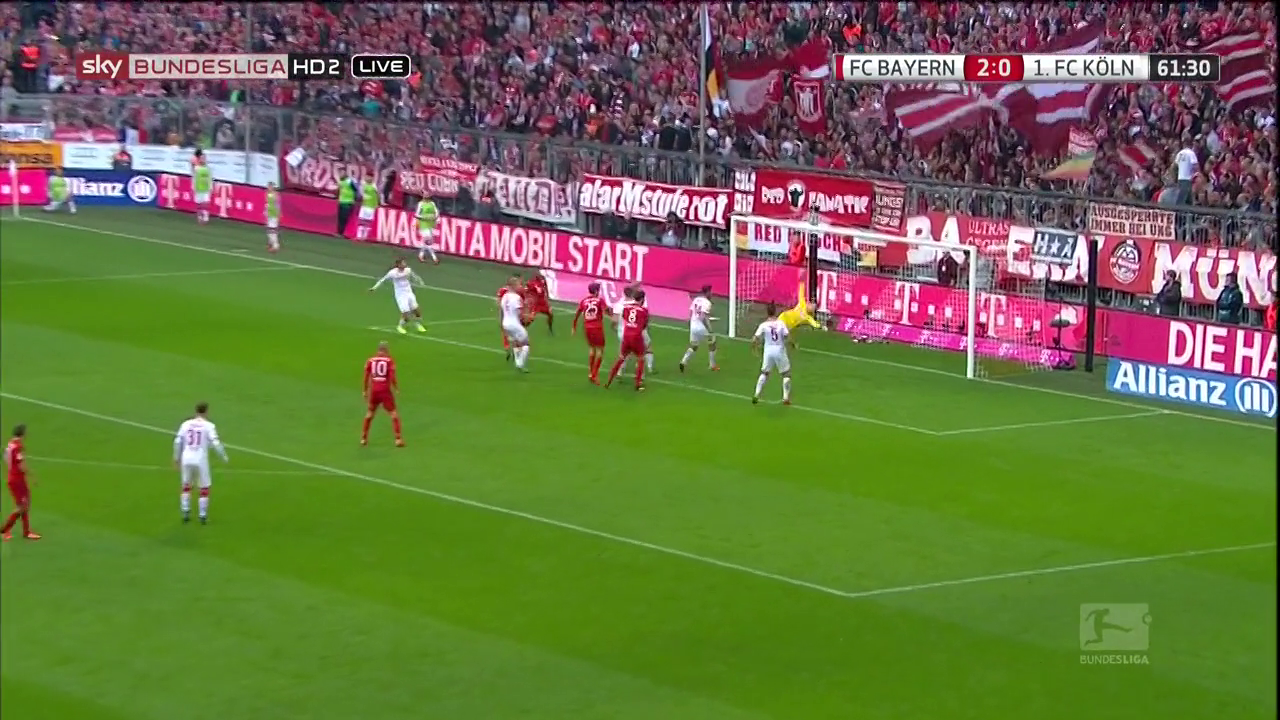

tensor([[-43.5825, -25.1149,   7.7778,  21.2190,  -1.9270,  12.7713,  38.2750,
         -34.9568, -27.7011, -25.5981]], device='cuda:0')
tensor([-43.5825, -25.1149,   7.7778,  21.2190,  -1.9270,  12.7713, -34.9568,
        -27.7011, -25.5981], device='cuda:0')
Prediction: Direct free-kick
Actual class: Goal
['Foul', 'Goal', 'Ball out of play', 'Direct free-kick', 'Clearance', 'Corner', 'Offside', 'Penalty', 'Yellow card', 'Kick-off']


In [ ]:
import matplotlib
from google.colab.patches import cv2_imshow
image_num = 1000

img = cv2.imread(test_data[image_num], cv2.IMREAD_COLOR)
cv2_imshow(img)

image = Image.open(test_data[image_num])
label = test_data[image_num].split('/')[-2]

image = square_pad(image)
# here we change the size of the images
image = image.resize((100, 100))
image = np.asarray(image)
image = test_transforms(image=image)["image"]
image = (image).float().unsqueeze(0).cuda()
model.to("cuda")
model.eval()

with torch.no_grad():
  y_hat = model(image)

print(y_hat)
y_hat = y_hat[y_hat!=torch.max(y_hat)]
print(y_hat)
print("Prediction:", classes[torch.argmax(y_hat)])
print("Actual class:", label)
print(classes)